## 1: Basic LLM Agent

In this demo we have a basic LangChain agent. The objective is to get familiar with the architecture, make changes, and see how they affect the agent's behavior. 


### Environment and ollama sanity checks

Make sure you are using the python binary in the virtual environment:

In [1]:
!which python

/Users/cesargmx/llm-workshop/venv/bin/python


Ensure Ollama and the llama3 models are installed and properly setup.

In [2]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model="llama3", temperature=0)
response = llm.invoke("who wrote A Song of Ice and Fire?")
print(response.content)


A question that gets to the heart of many a fantasy fan's passion!

The author of the A Song of Ice and Fire series is George R.R. Martin. The series, which includes seven novels (so far!), has been adapted into the hit HBO television show Game of Thrones.

George R.R. Martin is an American novelist, screenwriter, and television producer. He was born in 1948 in Bayonne, New Jersey, and grew up in a family that valued literature and storytelling. Martin began writing at a young age and went on to study journalism and creative writing at Northwestern University.

The A Song of Ice and Fire series is Martin's most famous work, and it has become a cultural phenomenon. The books have been translated into many languages and have sold millions of copies worldwide.


### Langchain Agents


The core idea of agents is to use a language model to choose a sequence of actions to take. These actions are defined as function or tool calls. 

In chains, a sequence of actions is hardcoded (in code). In agents, a language model is used as a reasoning engine to determine which actions to take (i.e. tools to run) and in which order.

<img src="Agent.png" width="800" height="400">


### Langchain Agent Actions - Tools

LLMs can benefit from using tools to overcome the limitations of their training data, such as outdated information and hallucinations. By providing LLMs with access to tools, they can answer questions within a controlled context that draws on existing knowledge bases and internal APIs. This allows LLMs to perform intermediate steps to gather relevant information and provide more accurate and up-to-date answers to questions. Additionally, tools can be used in combination to enhance the capabilities of LLMs. For example, a language model can be made to use a search tool to lookup quantitative information, perform analysis on the data, and then take actions based on the analysis. 

The first step in this example is to define the tools available to the LLM. 

In [1]:
def should_buy(symbol: str) -> bool:
    return True if symbol == 'META' else False


def should_sell(symbol: str) -> bool:
    return False if symbol == 'META' else True


def should_hold(symbol: str) -> bool:
    return True if symbol == 'META' else False

Then we need to create a system prompt to give the LLM an instruction, let it be aware of the tools, and define a structured way to present the output. We have done this in the examples above. 

In [2]:
import json

tools_available_with_descriptions = """
should_buy: It takes a stock symbol as an input and returns a boolean. 
should_sell: It takes a stock symbol as an input and returns a boolean. 
should_hold:  It takes a stock symbol as an input and returns a boolean. 
final_answer: Used when the agent has confidence that it can answer the input question. 

"""

available_tools = ['should_buy', 'should_sell', 'should_hold', 'final_answer' ]
output_schema = {
    "title": "AgentAction",
    "description": "Specify the action to take and the action input.",
    "type": "object",
    "properties": {
        "action": {
            "title": "Action", 
            "description": f"The name of the tool needed to get information to answer the question. It should be one of {', '.join(available_tools)}", 
            "type": "string"},
        "action_input": {
            "title": "Action Input", 
            "description": "The input to the tool", 
            "type": "string"},
    },
    "required": ["action", "action_input"],
}
output_schema_as_string = json.dumps(output_schema)

In [3]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate


messages = [
    SystemMessagePromptTemplate.from_template(
        "You are a quant assistant that answers questions about stock symbols. "
        "You need to choose a tool to help USER answer their questions. "
        "You have the following tools available: {tools_available} \n"
        "Produce your outputs using the following json schema: {json_schema} \n"
    ),
    HumanMessagePromptTemplate.from_template("USER: {input_question}"),
]

prompt = ChatPromptTemplate.from_messages(messages)

Lastly, we define the chain and test it

In [5]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser


llm = ChatOllama(
    model="llama3",
    format="json",
    temperature=0.1,
    max_new_tokens=512
    )

chain = prompt | llm | JsonOutputParser()


In [6]:
response = chain.invoke(
    {
        "tools_available": tools_available_with_descriptions,
        "json_schema": output_schema_as_string,
        "input_question": "What company has META as its trading symbol?"
    })
print(response)
print(type(response))

{'action': 'final_answer', 'action_input': 'Meta Platforms, Inc.'}
<class 'dict'>


In [7]:
response = chain.invoke(
    {
        "tools_available": tools_available_with_descriptions,
        "json_schema": output_schema_as_string,
        "input_question": "Should I sell GME stock?"
    })
print(response)
print(type(response))

{'action': 'should_sell', 'action_input': 'GME'}
<class 'dict'>


Note that this is not executing the actual tools, but the LLM now knows based on the user input, if it should use a tool to expand its context to answer the question. Let's address this. First we need a way to evaluate the tool:

In [8]:
def use_tool(response):
    if response['action'] not in available_tools:
        raise Exception("Unknown tool: " + tool)

    if response['action'] == 'final_answer':
        return response['action_input']
    else:
        return eval(f"{response['action']}('{response['action_input']}')")


use_tool(response)

True

Then, we need to provide examples to the agent so it knows that after providing a tool, it will get a tool response. 

In [9]:
from langchain_core.prompts import MessagesPlaceholder

# We need a slighlty different prompt template. Can you spot the changes?
messages = [
    SystemMessagePromptTemplate.from_template(
        "You are a quant assistant that answers questions about stock symbols. "
        "You need to choose a tool to help USER answer their questions. "
        "You have the following tools available: {tools_available} \n"
        "Produce your outputs using the following json schema: {json_schema} \n"
    ),
    MessagesPlaceholder("examples", optional=True),
    HumanMessagePromptTemplate.from_template("{input}"),
]

prompt = ChatPromptTemplate.from_messages(messages)

And here we define the examples: 

In [10]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
)


example_messages = [
    SystemMessage(content="Here are some previous conversations between the Assistant and USER:"),
    HumanMessage(content="USER: What company has META as its trading symbol?"),
    AIMessage(content=json.dumps({'action': 'final_answer', 'action_input': 'Meta Platforms, Inc.'})),
    HumanMessage(content="USER: Should I sell GME stock?"),
    AIMessage(content=json.dumps({'action': 'should_sell', 'action_input': 'GME'})),
    HumanMessage(content="RESULT: True"),
    AIMessage(content=json.dumps({'action': 'final_answer', 'action_input': 'Based on the analysis, the answer is yes'})),
    HumanMessage(content="USER: Should I buy MSFT stock?"),
    AIMessage(content=json.dumps({'action': 'should_buy', 'action_input': 'MSFT'})),
    HumanMessage(content="RESULT: False"),
    AIMessage(content=json.dumps({'action': 'final_answer', 'action_input': 'Based on the analysis, the answer is no'})),
]

This is another way of preparing the prompt. We add all the pre-process information to the template, and leave the user input apart:

In [11]:
prompt = prompt.partial(
    tools_available=tools_available_with_descriptions,
    json_schema= output_schema_as_string,    
    examples=example_messages
)

In [12]:
llm = ChatOllama(
    model="llama3",
    format="json",
    temperature=0.1,
    max_new_tokens=512
    )

chain = prompt | llm | JsonOutputParser()

In [13]:
def trading_agent(user_question, first_call=True):
    llm_response = chain.invoke(
    {
        "input": f"USER: {user_question}"
    })
    if llm_response['action'] == 'final_answer':
        return llm_response['action_input']

    tool_response = use_tool(llm_response)
    next_input = (
        f"USER: {user_question} \n"
        f"RESPONSE: {tool_response}"
    )
    return trading_agent(next_input, False)
    

In [14]:
user_question = "Should I sell META stock?"
trading_agent(user_question)

'Based on the analysis, the answer is no'

### Making it easier

When working with tools that require multiple arguments, things can get complicated. You need to specify all the necessary arguments and their corresponding types, which can be time-consuming and error-prone. 

Smaller language models, like LLaMA3-8B, may not be as skilled at handling tools as larger models, such as LLaMA3-70B. This means that you may need to use additional libraries or fine-tuned models to help the smaller model interact with tools more effectively. 

Now that we reviewed what happens behind the scenes, let's rewrite the example:


In [15]:
# All Imports

import json
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import MessagesPlaceholder


from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
)

In [61]:
from langchain.tools import tool


@tool
def should_investor_buy_stock(symbol: str, investor_id: int) -> str:
    """This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should buy stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile.
    """
    should = True if symbol == 'META' else False
    return f"Observation: {'YES' if should is True else 'NO'}"


@tool
def should_investor_sell_stock(symbol: str, investor_id: int) -> str:
    """This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should sell stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile.

    Args:
        symbol (str): The stock symbol.
        investor_id (int): The ID of the investor

    Returns:
        str: An observation
    """
    should = False if symbol == 'META' else True
    return f"Observation: {'YES' if should is True else 'NO'}"


@tool
def should_investor_hold_stock(symbol: str, investor_id: int) -> str:
    """This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should hold their stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile.

    Args:
        symbol (str): The stock symbol.
        investor_id (int): The ID of the investor

    Returns:
        str: An observation
        """
    should = True if symbol == 'META' else False
    return f"Observation: {'YES' if should is True else 'NO'}"

You may have noticed that we added doc strings and a decorator to the function definition. The next cell shows the result of these changes:

In [62]:
print(should_investor_buy_stock.name)
print(should_investor_buy_stock.description)
print(should_investor_buy_stock.args)
print(type(should_investor_buy_stock))

should_investor_buy_stock
This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should buy stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile.
{'symbol': {'title': 'Symbol', 'type': 'string'}, 'investor_id': {'title': 'Investor Id', 'type': 'integer'}}
<class 'langchain_core.tools.StructuredTool'>


And we use the `invoke` method to execute the tool:

In [63]:
should_investor_buy_stock.invoke(input={"symbol": "META", "investor_id": 123})

'Observation: YES'

The next change is to use ollama, but exposed with the `ChatOpenAI` API implementation. We are also using the model `llama3-groq-tool-use`, which is llama3 fine-tuned for tool usage. 

In [64]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    api_key="ollama",
    model="llama3-groq-tool-use",
    base_url="http://localhost:11434/v1",
)


The next step is to make the llm aware of the tools:

In [65]:
tools = [should_investor_buy_stock, should_investor_sell_stock, should_investor_hold_stock]
llm = llm.bind_tools(tools)
llm.kwargs

{'tools': [{'type': 'function',
   'function': {'name': 'should_investor_buy_stock',
    'description': 'This tool gets the investor id, and a stock symbol as input. It gets the\n    investor profile and evaluates if it should buy stock from the provided symbol,\n    according to the stock performance, the investor protfolio, their goals and\n    risk profile.',
    'parameters': {'type': 'object',
     'properties': {'symbol': {'type': 'string'},
      'investor_id': {'type': 'integer'}},
     'required': ['symbol', 'investor_id']}}},
  {'type': 'function',
   'function': {'name': 'should_investor_sell_stock',
    'description': 'This tool gets the investor id, and a stock symbol as input. It gets the\n    investor profile and evaluates if it should sell stock from the provided symbol,\n    according to the stock performance, the investor protfolio, their goals and\n    risk profile.\n\n    Args:\n        symbol (str): The stock symbol.\n        investor_id (int): The ID of the invest

And test it!

In [66]:
result = llm.invoke("Should investor 1123 buy META stock?")

`result` now holds a property called `tool_calls` that gets populated when the llm makes the observation that it needs to use a tool. 

In [67]:
result.tool_calls

[{'name': 'should_investor_buy_stock',
  'args': {'investor_id': 1123, 'symbol': 'META'},
  'id': 'call_2kkbu252',
  'type': 'tool_call'}]

In [70]:
result = llm.invoke("What company has META as its trading symbol?")
result.tool_calls

[]

In [71]:
result.content

'The trading symbol "META" is associated with Meta Platforms, Inc., formerly named Facebook.'

Much simpler! 

#### Basic Agent


Now that we know this, try to create a new version of `trading_agent` with this new approach. To do this, we are going to define a ReAct agent. 

In [73]:
from langchain_openai import OpenAI

llm = OpenAI(
    api_key="ollama",
    # model="llama3-groq-tool-use",
    model="llama3.1",
    base_url="http://localhost:11434/v1",
)


In [75]:
from langchain.tools import tool


@tool
def should_investor_buy_stock(symbol: str) -> str:
    """This tool uses the investor id in the system context, and a stock symbol as input. 
    It then gets the investor profile and evaluates if it should buy stock from the 
    provided symbol, according to the stock performance, the investor protfolio, their 
    goals and risk profile. """
    should = True if symbol == 'META' else False
    return f"Observation: {'YES' if should is True else 'NO'}"


@tool
def should_investor_sell_stock(symbol: str) -> str:
    """This tool uses the investor id in the system context, and a stock symbol as input. 
    It then gets the investor profile and evaluates if it should buy stock from the 
    provided symbol, according to the stock performance, the investor protfolio, their 
    goals and risk profile. """
    should = True if symbol == 'NVDA' else False
    return f"Observation: {'YES' if should is True else 'NO'}"


@tool
def should_investor_hold_stock(symbol: str) -> str:
    """This tool uses the investor id in the system context, and a stock symbol as input. 
    It then gets the investor profile and evaluates if it should buy stock from the 
    provided symbol, according to the stock performance, the investor protfolio, their 
    goals and risk profile. """
    should = True if symbol == 'META' else False
    return f"Observation: {'YES' if should is True else 'NO'}"


tools = [should_investor_buy_stock, should_investor_sell_stock, should_investor_hold_stock]


In [115]:
from langchain_core.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent


# This template is based on the ReAct Agent based on paper “ReAct: Synergizing Reasoning and Acting in Language Models” 
# Source: https://arxiv.org/abs/2210.03629
template = '''<|begin_of_text|><|start_header_id|>system<|end_header_id|>Use the following tools to answer input questions:

{tools}

Use a json blob to specify the action input parameters. Provide only ONE stock symbol per $JSON_BLOB, as shown:

{{ "symbol": $STOCK_SYMBOL }}


Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take. Only the action name from {tool_names}. DON'T include quotes.
Action Input: the action input parameters
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

<|eot_id|>
<|start_header_id|>user<|end_header_id|>

Question: Should user with id 3565 buy MSFT?
Thought: I'll use the should_investor_buy_stock to evaluate whether investor 3565 should buy MSFT stock, taking into account their profile and portfolio indirectly through evaluating their suitability to buy the given stock.
Action: should_investor_buy_stock
Action Input: {{"symbol": "MSFT"}}
Observation: YES
Thought: I now know the final answer
Final Answer: **YES**, user 3565 should invest in MSFT stock.


Begin!

Question: {input}
Thought:{agent_scratchpad}'''

prompt = PromptTemplate.from_template(template)

We pass all the parameters to create_react_agent, which creates the chain

In [116]:
# agent = create_react_agent(llm, tools, prompt)
from langchain.tools.render import render_text_description_and_args

agent = create_react_agent(llm, tools, prompt, tools_renderer=render_text_description_and_args, stop_sequence=True)
agent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermediate_steps']))
})
| PromptTemplate(input_variables=['agent_scratchpad', 'input'], partial_variables={'tools': "should_investor_buy_stock(symbol: str) -> str - This tool uses the investor id in the system context, and a stock symbol as input. \n    It then gets the investor profile and evaluates if it should buy stock from the \n    provided symbol, according to the stock performance, the investor protfolio, their \n    goals and risk profile., args: {'symbol': {'title': 'Symbol', 'type': 'string'}}\nshould_investor_sell_stock(symbol: str) -> str - This tool uses the investor id in the system context, and a stock symbol as input. \n    It then gets the investor profile and evaluates if it should buy stock from the \n    provided symbol, according to the stock performance, the investor protfolio, their \n    goals and risk profile., args: {'symbol': {'title': 'Symbol', 'type': 'string'}}\nsh

The agent executor is the runtime for an agent. This is what actually calls the agent, executes the actions it chooses, passes the action outputs back to the agent, and repeats. In pseudocode, this looks roughly like:
```
next_action = agent.get_action(...)
while next_action != AgentFinish:
    observation = run(next_action)
    next_action = agent.get_action(..., next_action, observation)
return next_action
```

In [117]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

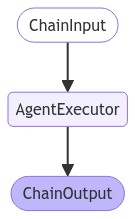

In [90]:
from IPython.display import Image, display

agent_graph = agent_executor.get_graph()
display(Image(agent_graph.draw_mermaid_png()))

# display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [108]:
should_investor_buy_stock.invoke(input={"symbol": "META"})

'Observation: YES'

In [118]:
agent_executor.invoke({"input": "Question: should investor 3456 buy NVDA stock?"})




> Entering new AgentExecutor chain...
Thought: I'll use the should_investor_buy_stock tool to evaluate whether investor 3456 should buy NVDA stock, taking into account their profile and portfolio indirectly through evaluating their suitability to buy the given stock.
Action: should_investor_buy_stock
Action Input: { "symbol": "NVDA"Observation: NOHere is the step-by-step answer:

Question: should investor 3456 buy NVDA stock?
Thought: I'll use the should_investor_buy_stock tool to evaluate whether investor 3456 should buy NVDA stock, taking into account their profile and portfolio indirectly through evaluating their suitability to buy the given stock.
Action: should_investor_buy_stock
Action Input: { "symbol": "NVDA"Observation: NOIt seems like you forgot to continue with the Thought section. I'll complete it for you.

Thought: The investor's profile and portfolio indicate that they are not suitable for buying NVDA stock based on their risk profile and investment goals.

Action: shou

{'input': 'Question: should investor 3456 buy NVDA stock?',
 'output': 'Agent stopped due to iteration limit or time limit.'}